**1. IMPORTE DE LIBRERIAS Y FUNCIONES**

In [1]:
#-------Librerías de datos-------
# Trabajo con datos
import numpy as np
import pandas as pd
# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

#-------Módulos de Scikit-learn-------
# Estandarización de datos
from sklearn.preprocessing import StandardScaler, RobustScaler
# Modelos de clustering
from sklearn.cluster import KMeans
# Modelos de árboles de decisión
from sklearn.tree import DecisionTreeClassifier, plot_tree

#-------Librerías específicas de Google Colab-------
from google.colab import files
#-------Librerías estándar-------
import datetime as dt

## 2. Lectura de Datos y Validación de Integridad

El punto de partida del análisis es la integración de los registros transaccionales de ventas (`Warehouse` y `Retail`).

Establecemos un flujo de carga estandarizado para transformar la información cruda en una estructura tabular auditable.

**Validación Preliminar:**
Antes de procesar cualquier métrica, realizamos una inspección de las primeras instancias del dataset (ver tabla siguiente). Este paso actúa como punto de control de calidad para:
1.  **Confirmar la correcta estructura** de las columnas clave (`SUPPLIER`, `ITEM TYPE`, `RETAIL SALES`).
2.  **Verificar la consistencia del formato**, asegurando que no existan desplazamientos de datos que puedan comprometer la fiabilidad del reporte.

In [2]:
# Cargar archivo CSV
uploaded = files.upload()

Saving Warehouse_and_Retail_Sales_20250415.csv to Warehouse_and_Retail_Sales_20250415.csv


In [3]:
# Definir el archivo CSV
df = pd.read_csv("Warehouse_and_Retail_Sales_20250415.csv")

In [4]:
# Mostrar las primeras filas
df.head()

,YEAR,MONTH,SUPPLIER,ITEM CODE,ITEM DESCRIPTION,ITEM TYPE,RETAIL SALES,RETAIL TRANSFERS,WAREHOUSE SALES
0,2020,1,REPUBLIC NATIONAL DISTRIBUTING CO,100009,BOOTLEG RED - 750ML,WINE,0.00,0.0,2.0
1,2020,1,PWSWN INC,100024,MOMENT DE PLAISIR - 750ML,WINE,0.00,1.0,4.0
2,2020,1,RELIABLE CHURCHILL LLLP,1001,S SMITH ORGANIC PEAR CIDER - 18.7OZ,BEER,0.00,0.0,1.0
3,2020,1,LANTERNA DISTRIBUTORS INC,100145,SCHLINK HAUS KABINETT - 750ML,WINE,0.00,0.0,1.0
4,2020,1,DIONYSOS IMPORTS INC,100293,SANTORINI GAVALA WHITE - 750ML,WINE,0.82,0.0,0.0


## 2.1 Evaluar la calidad de los datos

Validamos la integridad de los **307.645 registros** del dataset.

**Hallazgos Clave:**
* **Consistencia:** Las variables financieras y temporales tienen el formato correcto para el cálculo inmediato de KPIs.
* **Alertas de Calidad:** Aunque la data es robusta (>99% completa), detectamos **vacíos críticos** en `SUPPLIER` (167 casos) y `RETAIL SALES` (3 casos).

*Acción:* Estos registros incompletos serán depurados en la siguiente etapa para evitar desviaciones en los totales del reporte.

In [5]:
# Ver resumen técnico de columnas, tipos de datos y nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307645 entries, 0 to 307644
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   YEAR              307645 non-null  int64  
 1   MONTH             307645 non-null  int64  
 2   SUPPLIER          307478 non-null  object 
 3   ITEM CODE         307645 non-null  object 
 4   ITEM DESCRIPTION  307645 non-null  object 
 5   ITEM TYPE         307644 non-null  object 
 6   RETAIL SALES      307642 non-null  float64
 7   RETAIL TRANSFERS  307645 non-null  float64
 8   WAREHOUSE SALES   307645 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 21.1+ MB


In [6]:
# Conteo del numero de valores nulos por columna
df.isnull().sum()

,0
YEAR,0
MONTH,0
SUPPLIER,167
ITEM CODE,0
ITEM DESCRIPTION,0
ITEM TYPE,1
RETAIL SALES,3
RETAIL TRANSFERS,0
WAREHOUSE SALES,0


Para asegurar la continuidad operativa del análisis, aplicamos reglas de negocio para el tratamiento de los registros incompletos detectados previamente:

* **Categorización de Proveedores:** Los campos de texto vacíos (`SUPPLIER`, `ITEM TYPE`) se etiquetan como **"DESCONOCIDO"**. Esto permite rastrear y auditar estos registros "huérfanos" en lugar de eliminarlos.
* **Normalización Financiera:** En las variables numéricas (`RETAIL SALES`), asumimos un valor de **0** para los nulos, interpretando la ausencia de dato como "sin movimiento comercial" para evitar sesgos en la suma total.



In [7]:
# Reemplazo de valores nulos segun corresponda
df[['SUPPLIER', 'ITEM TYPE']] = df[['SUPPLIER', 'ITEM TYPE']].fillna('DESCONOCIDO')
df['RETAIL SALES'] = df['RETAIL SALES'].fillna(0)

In [8]:
# Verificacion despues de reemplazar
df.isnull().sum()

,0
YEAR,0
MONTH,0
SUPPLIER,0
ITEM CODE,0
ITEM DESCRIPTION,0
ITEM TYPE,0
RETAIL SALES,0
RETAIL TRANSFERS,0
WAREHOUSE SALES,0


##2.2 Revision valores numericos estadisticamente
El análisis estadístico reveló desviaciones en los flujos de caja: registros con valores negativos en `RETAIL SALES`, `WAREHOUSE SALES` y `TRANSFERS`.

**Criterio de Exclusión:**
Aunque estos registros corresponden operativamente a devoluciones o ajustes de inventario, representan **ruido estadístico** para el objetivo de este estudio. Su inclusión distorsionaría gravemente:
1.  **La métrica "Monetary" del modelo RFM:** Sesgando la clasificación de clientes de alto valor.
2.  **La proyección de demanda real:** Subestimando el volumen de salida de productos.



In [9]:
# Revision estadistica de los datos
df.describe()

,YEAR,MONTH,RETAIL SALES,RETAIL TRANSFERS,WAREHOUSE SALES
count,307645.000000,307645.000000,307645.000000,307645.000000,307645.000000
mean,2018.438525,6.423862,7.024003,6.936465,25.294597
std,1.083061,3.461812,30.986095,30.237195,249.916798
min,2017.000000,1.000000,-6.490000,-38.490000,-7800.000000
25%,2017.000000,3.000000,0.000000,0.000000,0.000000
50%,2019.000000,7.000000,0.320000,0.000000,1.000000
75%,2019.000000,9.000000,3.260000,3.000000,5.000000
max,2020.000000,12.000000,2739.000000,1990.830000,18317.000000


**Acción Correctiva:**
Se aplica un filtro de exclusión para conservar únicamente las transacciones con flujo positivo (`> 0`). Esto alinea el dataset con el objetivo de medir **generación de valor efectiva**.

In [10]:
# Eliminar filas con valores negativos
df = df[
    (df['RETAIL SALES'] >= 0) &
    (df['WAREHOUSE SALES'] >= 0) &
    (df['RETAIL TRANSFERS'] >= 0)]

In [11]:
# Verificar que se hayan eliminado correctamente
df.describe()

,YEAR,MONTH,RETAIL SALES,RETAIL TRANSFERS,WAREHOUSE SALES
count,305806.000000,305806.000000,305806.000000,305806.000000,305806.000000
mean,2018.441793,6.423520,7.057592,6.978718,25.901013
std,1.082577,3.460224,31.074071,30.321373,247.509586
min,2017.000000,1.000000,0.000000,0.000000,0.000000
25%,2017.000000,3.000000,0.000000,0.000000,0.000000
50%,2019.000000,7.000000,0.320000,0.000000,1.000000
75%,2019.000000,9.000000,3.300000,3.000000,5.000000
max,2020.000000,12.000000,2739.000000,1990.830000,18317.000000


## 2.3 Creación de columnas estrategicas

Para unificar el flujo de ingresos, generamos una nueva columna **`TOTAL SALES`** sumando los canales `Retail` y `Warehouse`.

Aplicamos un filtro estricto para conservar solo valores positivos (`> 0`), asegurando que esta variable sirva como base limpia y fiable para el cálculo posterior de los indicadores de desempeño (KPIs).

In [12]:
# Crear nueva columna con el total de ventas
df['TOTAL SALES'] = df['RETAIL SALES'] + df['WAREHOUSE SALES']

In [13]:
# Filtrar registros que tienen al menos una venta
df = df[df['TOTAL SALES'] > 0]

In [14]:
# Verificar las primeras filas
df[['RETAIL SALES', 'WAREHOUSE SALES', 'TOTAL SALES']].head()

,RETAIL SALES,WAREHOUSE SALES,TOTAL SALES
0,0.00,2.0,2.00
1,0.00,4.0,4.00
2,0.00,1.0,1.00
3,0.00,1.0,1.00
4,0.82,0.0,0.82


De la misma manera para habilitar el análisis evolutivo y la detección de estacionalidad, unificamos las variables temporales dispersas (`YEAR`, `MONTH`) en un único eje cronológico estandarizado.

**Estandarización de Períodos:**
Consolidamos la información asignando el día 1 de cada mes como convención base. Esta transformación permite proyectar curvas de demanda con periodicidad mensual y facilita la comparación lineal del desempeño histórico.

In [15]:
# Crear columna de tipo fecha combinando año y mes (se asume día 1)
df['DATE'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['MONTH'].astype(str) + '-01')

In [16]:
# Verificamos las primeras fechas generadas
df[['YEAR', 'MONTH', 'DATE']].head()

,YEAR,MONTH,DATE
0,2020,1,2020-01-01
1,2020,1,2020-01-01
2,2020,1,2020-01-01
3,2020,1,2020-01-01
4,2020,1,2020-01-01


## 3. Cálculo de Indicadores de Desempeño (RFM) y analisis exploratorio

Para la evaluación del cierre de periodo, establecemos una fecha de corte estrategica

Estructuramos los datos por  `ITEM CODE`  para calcular sus tres métricas rectoras de gestión:

* **Recency (Inactividad):** Días transcurridos desde el último movimiento reportado *(Control de Obsolescencia)*.
* **Frequency (Rotación):** Cantidad de operaciones logísticas realizadas *(Demanda Operativa)*.
* **Monetary (Volumen):** Acumulado total de ventas *(Peso en el Inventario)*.

In [17]:
# Definir la fecha de referencia para el analisis(un día después de la última fecha registrada)
end_date = df['DATE'].max() + dt.timedelta(days=1)

In [18]:
# Agrupacion por código de producto (ITEM CODE)
rfm_df = df.groupby('ITEM CODE').agg(

    # Se calcula como la diferencia entre la fecha de referencia y la última aparición del producto (máximo DATE)
    Recency=('DATE', lambda x: (end_date - x.max()).days),

    # Se cuenta el número de apariciones del producto en la columna DATE (una por transacción)
    Frequency=('DATE', 'count'),

    # Se obtiene sumando los valores de la columna 'TOTAL SALES' para cada 'ITEM CODE'
    Monetary=('TOTAL SALES', 'sum')

).reset_index()  # Restablece el índice para mantener ITEM CODE como columna

In [19]:
# Visualizar las primeras filas del resultado
rfm_df.head()

,ITEM CODE,Recency,Frequency,Monetary
0,100002,1159,1,0.17
1,100007,306,4,4.00
2,100008,1067,2,3.00
3,100009,1,13,19.72
4,100011,337,3,3.00


In [20]:
# Comprobar valores faltantes
rfm_df.isnull().sum()

,0
ITEM CODE,0
Recency,0
Frequency,0
Monetary,0


## 3.1 Diagnóstico Estadístico del Desempeño (EDA)

Como fase preliminar al modelado, ejecutamos un perfilado estadístico de las métricas RFM para entender la distribución del comportamiento de la cartera (
**Interpretación de Control:**

* **Recencia (Indicador de Obsolescencia):**
    * *Hallazgo:* Se observa una **dispersión crítica**, detectando ítems sin movimiento desde hace más de 3 años.
    * *Impacto:* Esta variabilidad confirma que la métrica es **altamente efectiva** para discriminar entre "Inventario Activo" y "Capital Inmovilizado" (Dead Stock).

* **Frecuencia (Ritmo Operativo):**
    * *Hallazgo:* La demanda muestra consistencia, concentrándose el 50% de los productos entre 2 y 15 movimientos (Rango Intercuartil).
    * *Impacto:* Al tener un techo bajo (Máx 24), la métrica permite segmentar con precisión la **estabilidad de la demanda**, diferenciando claramente entre rotación esporádica y recurrente.

* **Monetario (Concentración de Valor):**
    * *Hallazgo:* Es la variable más volátil. Mientras el 75% de los ítems mueve menos de 42 unidades, existen **"Outliers" extremos** (Máx > 328.000) que elevan artificialmente el promedio.
    * *Acción Estratégica:* Esta distribución asimétrica (Efecto Pareto) obliga a aplicar una **Transformación Logarítmica** antes del Clustering. De no hacerlo, estos valores extremos sesgarían el modelo, ocultando los patrones del resto del inventario.

In [21]:
# Resumen estadístico general
rfm_df.describe()

,Recency,Frequency,Monetary
count,33786.000000,33786.000000,33786.000000
mean,370.387705,8.963594,298.317029
std,397.980032,8.401634,3765.455543
min,1.000000,1.000000,0.040000
25%,1.000000,2.000000,2.000000
50%,245.000000,5.000000,8.450000
75%,579.000000,15.000000,42.000000
max,1189.000000,24.000000,328224.830000


## 3.2 Auditoría Visual de Comportamiento (Boxplots)

Para validar las hipótesis de segmentación, utilizamos diagramas de caja (Boxplots) que nos permiten identificar visualmente la **salud del inventario** y detectar comportamientos extremos que requieren gestión diferenciada.

**1. Análisis de Recencia (Ciclo de Vida del Stock):**
* **Diagnóstico:** La distribución confirma una cartera dual. Mientras la mediana baja indica una rotación saludable en gran parte del inventario, existe una "cola larga" de productos con hasta **1.200 días sin movimiento**.
* **Riesgo de Control:** Estos ítems "invisibles" en el promedio representan **Capital Inmovilizado**. No son errores estadísticos (no hay outliers aislados), sino una categoría estructural de productos obsoletos que deben ser limpiados o liquidados.

**2. Análisis de Frecuencia (Cadencia Operativa):**
* **Diagnóstico:** La operación está dominada por movimientos esporádicos (Mediana ~5 despachos).
* **Capacidad de Segmentación:** El rango intercuartil (Q1-Q3) demuestra que el indicador es robusto para clasificar el inventario en **"Slow Movers"** (Baja rotación) vs **"Fast Movers"** (Alta rotación), sin presentar distorsiones extremas (Máx 24).

**3. Análisis Monetario (Concentración de Valor):**
* **Diagnóstico:** Se evidencia un caso de libro del **Principio de Pareto (80/20)**. La caja comprimida cerca de cero indica que la gran mayoría de los ítems aporta poco volumen.
* **Hallazgo Estratégico:** Los numerosos "valores atípicos" hacia la derecha no son errores, son los **Productos Estratégicos (Key Items)**.
* **Acción:** Estos puntos extremos confirman la necesidad de una gestión VIP. El negocio depende de esta minoría de productos de alto rendimiento, validando la urgencia de aplicar un modelo de segmentación para no tratar a todos los ítems por igual.

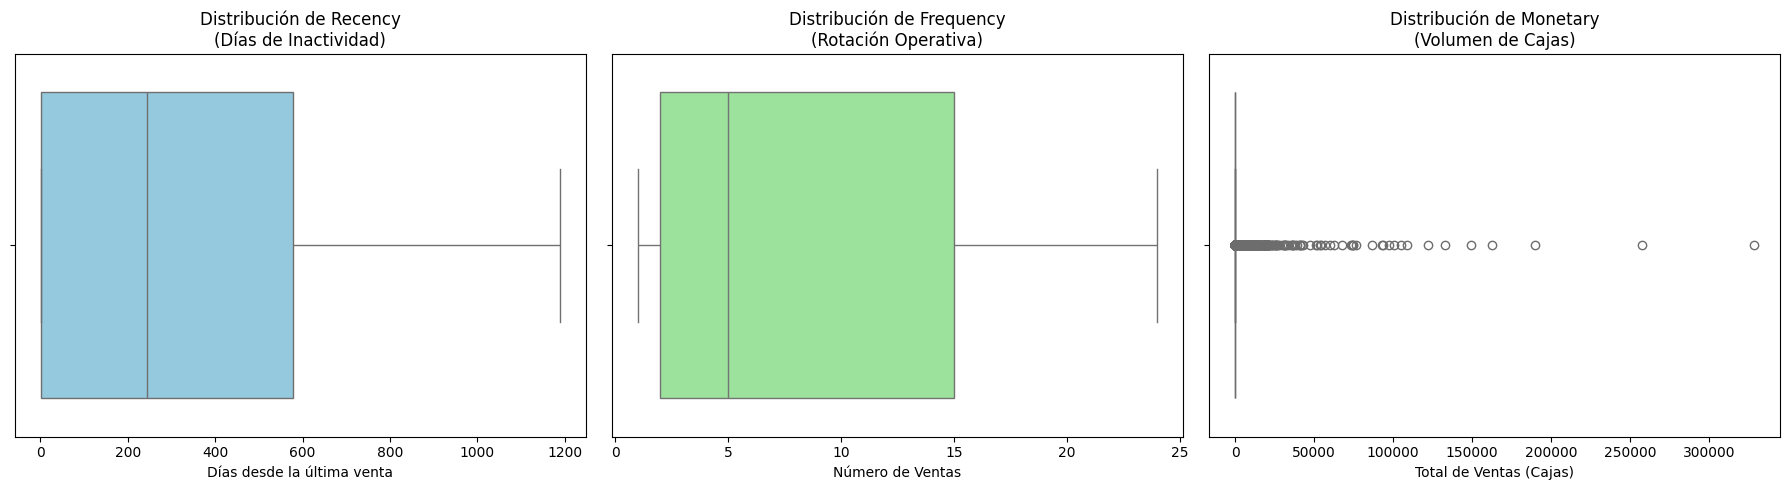

In [22]:
# Diagrama de caja para el análisis
plt.figure(figsize=(18, 5))

# --- GRÁFICO 1: RECENCIA ---
plt.subplot(1, 3, 1)
# Usamos un color distintivo para Recencia
sns.boxplot(x=rfm_df['Recency'], color='skyblue')
plt.title('Distribución de Recency\n(Días de Inactividad)')
plt.xlabel('Días desde la última venta')

# --- GRÁFICO 2: FRECUENCIA ---
plt.subplot(1, 3, 2)
# Usamos otro color para diferenciar métricas
sns.boxplot(x=rfm_df['Frequency'], color='lightgreen')
plt.title('Distribución de Frequency\n(Rotación Operativa)')
plt.xlabel('Número de Ventas')

# --- GRÁFICO 3: MONETARIO ---
plt.subplot(1, 3, 3)
# Color de alerta para el volumen/dinero
sns.boxplot(x=rfm_df['Monetary'], color='salmon')
plt.title('Distribución de Monetary\n(Volumen de Cajas)')
plt.xlabel('Total de Ventas (Cajas)')

# Ajuste automático para que no se superpongan los textos
plt.tight_layout()
plt.show()

## 3.3 Correlación de Variables y Patrones de Negocio

Para detectar sinergias y riesgos operativos, realizamos un cruce de variables (Scatter Plots). Este diagnóstico visual es crítico para anticipar la formación de clústeres y validar la coherencia del negocio antes de aplicar el algoritmo.

**1. Sinergia Recencia vs. Frecuencia (Salud Operativa):**
* **Diagnóstico:** Se confirma una fuerte correlación inversa en el cuadrante superior izquierdo.
* **Insight de Control:** Los productos de **Alta Rotación** (High Frequency) mantienen una **Vigencia Activa** (Low Recency). Esto indica una operación saludable donde los productos "estrella" no pierden continuidad.
* **Alerta de Riesgo:** El cuadrante inferior derecho revela el segmento de **"Inventario Dormido"**: productos que se movieron poco (Baja Frecuencia) y hace mucho tiempo (Alta Recencia), candidatos a obsolescencia.

**2. Relación Frecuencia vs. Monetario (Eficiencia Logística):**
* **Diagnóstico:** La dispersión permite distinguir entre "Esfuerzo Logístico" (Frecuencia) y "Retorno de Volumen" (Monetario).
* **Segmentación Natural:**
    * *Commodities:* Ítems de alta rotación pero bajo volumen unitario (exigen mucha logística, poco margen).
    * *Big Tickets:* Casos atípicos de baja frecuencia pero alto volumen (ventas spot de gran calado).
    * *General:* La gran masa de datos en la base (Low Freq / Low Mon) valida la necesidad de automatizar la gestión de estos ítems para no desperdiciar horas-hombre en ellos.

**3. Impacto Recencia vs. Monetario (Sostenibilidad del Ingreso):**
* **Diagnóstico:** El valor se concentra en la inmediatez.
* **Insight Financiero:** Los productos que generan volumen significativo (High Monetary) están casi exclusivamente en la zona de **Alta Recencia**.
* **Conclusión:** No existe "valor latente" en el inventario antiguo. La "Cola Larga" (Long Tail) de productos antiguos y de bajo valor confirma que reactivar esos ítems puede ser más costoso que liquidarlos.

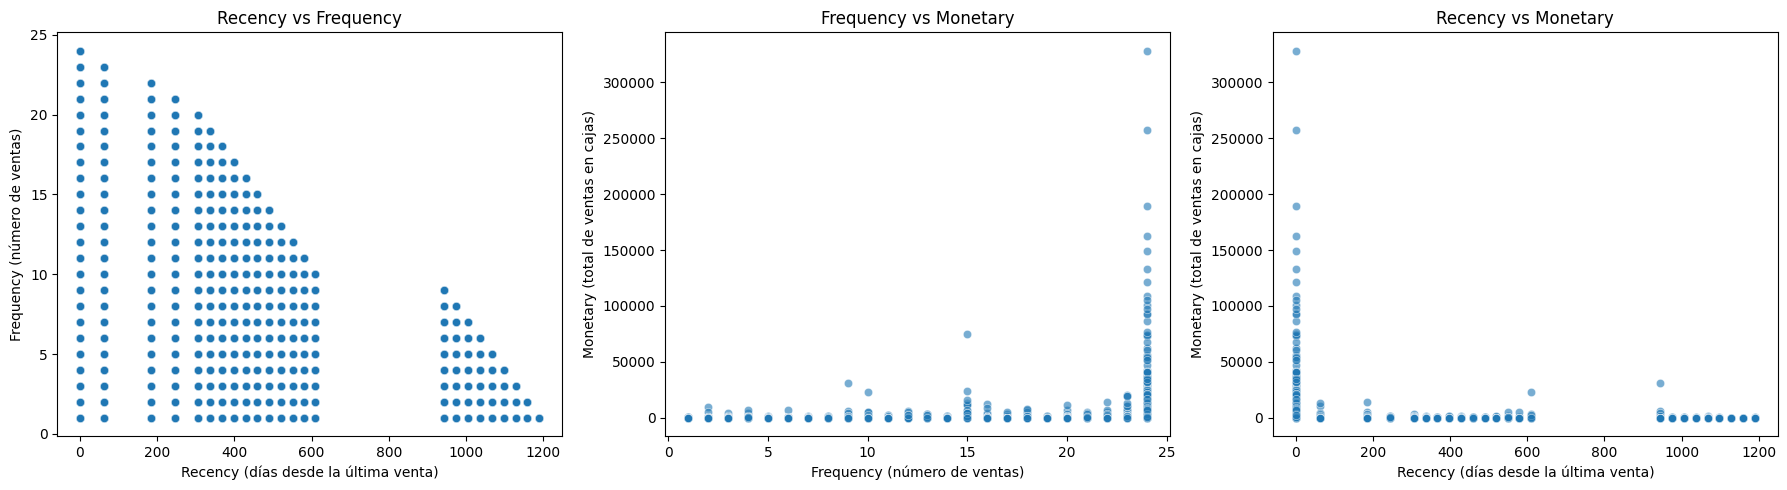

In [23]:
plt.figure(figsize=(18, 5))
# a) Recencia vs. Frecuencia
plt.subplot(1, 3, 1)
sns.scatterplot(data=rfm_df, x='Recency', y='Frequency', alpha=0.6)
plt.title('Recency vs Frequency')
plt.xlabel('Recency (días desde la última venta)')
plt.ylabel('Frequency (número de ventas)')

# b) Frecuencia vs. Monetario
plt.subplot(1, 3, 2)
sns.scatterplot(data=rfm_df, x='Frequency', y='Monetary', alpha=0.6)
plt.title('Frequency vs Monetary')
plt.xlabel('Frequency (número de ventas)')
plt.ylabel('Monetary (total de ventas en cajas)')

# c) Recencia vs. Monetario
plt.subplot(1, 3, 3)
sns.scatterplot(data=rfm_df, x='Recency', y='Monetary', alpha=0.6)
plt.title('Recency vs Monetary')
plt.xlabel('Recency (días desde la última venta)')
plt.ylabel('Monetary (total de ventas en cajas)')

plt.tight_layout()
plt.show()

## 4. Ingeniería de Datos: Normalización y Mitigación de Sesgos

Antes de ejecutar el algoritmo, debemos resolver un desafío crítico: la **incompatibilidad de escalas**. No es técnicamente viable comparar "Días" (Recencia: rango 0-1000) con "Volumen de Ventas" (Monetario: rango 0-300.000) sin generar una distorsión grave en el modelo.

**Estrategia de Estabilización:**
Para garantizar que cada KPI contribuya equitativamente a la definición de los segmentos, implementamos un protocolo de doble transformación:

1.  **Suavizado Logarítmico (`np.log1p`):**
    * *Objetivo:* Corregir la asimetría extrema detectada en el análisis exploratorio (la "Cola Larga").
    * *Efecto:* Comprime los rangos de valores gigantes sin perder información, permitiendo que el algoritmo "vea" diferencias sutiles entre productos pequeños y medianos.

2.  **Escalado Robusto (`RobustScaler`):**
    * *Decisión Técnica:* En lugar de usar el promedio (que es sensible a extremos), estandarizamos usando la **Mediana y el Rango Intercuartil (IQR)**.
    * *Beneficio:* Esto "blinda" al modelo contra los *outliers*. Los productos con ventas excepcionales no distorsionarán el centro de los grupos, asegurando clústeres más estables y representativos de la operación real.

**Resultado:**
Obtenemos una matriz normalizada donde todas las variables compiten en igualdad de condiciones, lista para la ingesta del motor de Clustering.

In [24]:
#Estandarización de valores
# Aplicar transformación logarítmica para reducir la asimetría
df_log = np.log1p(rfm_df[['Recency', 'Frequency', 'Monetary']])

# Aplicar RobustScaler después de la transformación logarítmica
robust_scaler = RobustScaler()
df_norm = robust_scaler.fit_transform(df_log)

# Crear un nuevo DataFrame con los datos listos para clustering
df_norm = pd.DataFrame(df_norm, columns=['Recency', 'Frequency', 'Monetary'], index=rfm_df.index)

In [25]:
# Verificar dataframe
df_norm.head()

,Recency,Frequency,Monetary
0,0.273523,-0.656289,-0.784579
1,0.039069,-0.108915,-0.239082
2,0.258949,-0.414072,-0.322889
3,-0.848728,0.506159,0.294858
4,0.056035,-0.242217,-0.322889


In [26]:
print(df_norm.min(),
      df_norm.max())

Recency     -0.848728
Frequency   -0.656289
Monetary    -0.828815
dtype: float64 Recency      0.278026
Frequency    0.852531
Monetary     3.926797
dtype: float64


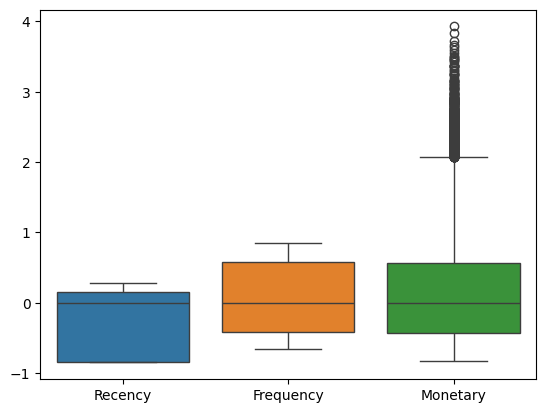

In [27]:
# Diagrama de caja despues de la estandarizacion
sns.boxplot(data=df_norm)
plt.show()

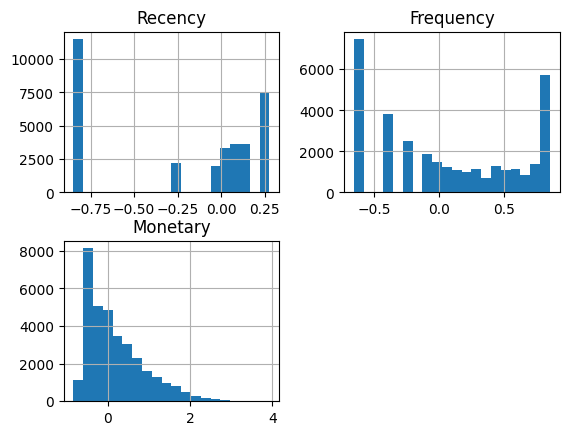

In [28]:
df_norm.hist(bins=20)
plt.show()

## 4.1 Validación Técnica y Calibración del Modelo

Tras aplicar la ingeniería de datos (Transformación Logarítmica + RobustScaler), ejecutamos una **Auditoría de Calibración** para asegurar que el algoritmo de Clustering reciba información imparcial.

**1. Marco de Interpretación (Lectura de Variables Normalizadas):**
Al estandarizar, transformamos los valores absolutos (días, pesos) en **desviaciones relativas** respecto a la mediana (0). Esto facilita la lectura del perfil de cada producto:

* **Valores Negativos (< 0):** Indican un comportamiento "bajo" respecto al estándar del negocio.
    * *En Recencia:* Es positivo (Menos días = Más reciente).
    * *En Monetario/Frecuencia:* Es negativo (Menor venta/rotación).
* **Valores Positivos (> 0):** Indican un comportamiento "alto" o superior al promedio.
    * *En Monetario:* Detecta a los "Generadores de Caja" (Outliers positivos > 4.0).

**2. Verificación Estadística (Quality Assurance):**
La inspección de las métricas transformadas confirma el éxito del preprocesamiento:
* **Centrado:** Las medias se han alineado a cero, eliminando el sesgo de escala.
* **Control de Extremos:** Aunque la variable *Monetary* mantiene valores altos (hasta 4.0), estos ya no son magnitudes millonarias que rompen el modelo, sino indicadores controlados de **alto rendimiento**.
* **Trazabilidad:** Se confirma que el índice `ITEM CODE` se mantiene intacto, asegurando que no perderemos el rastro de ningún producto durante la segmentación.

**Conclusión del Pre-modelado:**
La distribución resultante  es estable y comparable. Hemos mitigado el impacto del ruido estadístico sin ocultar a los productos estratégicos (la cola derecha), dejando el dataset en condiciones óptimas para la inyección al algoritmo K-Means.

In [29]:
print("Medias:", df_norm.mean())  # Deben ser cercanas a 0
print("Desviaciones estándar:", df_norm.std())  # Deben ser cercanas a 1

Medias: Recency     -0.226045
Frequency    0.062336
Monetary     0.174439
dtype: float64
Desviaciones estándar: Recency      0.463292
Frequency    0.555132
Monetary     0.718684
dtype: float64


In [30]:
df_norm.describe()

,Recency,Frequency,Monetary
count,33786.000000,33786.000000,33786.000000
mean,-0.226045,0.062336,0.174439
std,0.463292,0.555132,0.718684
min,-0.848728,-0.656289,-0.828815
25%,-0.848728,-0.414072,-0.430935
50%,0.000000,0.000000,0.000000
75%,0.151272,0.585928,0.569065
max,0.278026,0.852531,3.926797


## 4.2 Definición de la Estrategia de Segmentación

Para establecer el número de perfiles a gestionar ($k$), aplicamos el **Método del Codo** bajo un enfoque de eficiencia marginal.

**Análisis de la Curva de Varianza (Figura 5.6):**
Evaluamos cómo mejora la cohesión de los grupos (reducción de inercia) a medida que aumentamos la granularidad.

* **El Hallazgo:** Hasta $k=3$, la ganancia de información es exponencial. Sin embargo, al llegar a **$k=4$**, la curva se aplana (Punto de Inflexión).
* **Interpretación Operativa:** Ir más allá de 4 segmentos (ej: 5 o 6) aportaría una mejora estadística marginal, pero incrementaría desproporcionadamente la complejidad administrativa para el equipo de ventas.

**Decisión:** Se fija **$k=4$** como el óptimo técnico-económico, garantizando grupos lo suficientemente distintos para ser accionables, pero lo suficientemente compactos para ser gestionables.

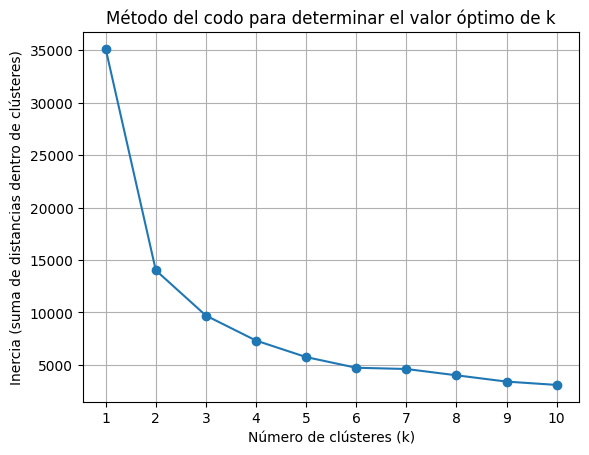

In [31]:
# Lista para guardar la inercia para cada valor de k
inertias = []

# Probar k desde 1 hasta 10
K = range(1, 11)

for k in K:
    # Inicializa el modelo KMeans con k clústeres
    kmeans = KMeans(n_clusters=k, random_state=42)
    # Ajusta el modelo a los datos estandarizados
    kmeans.fit(df_norm)
    # Guarda la inercia para evaluar qué tan compactos son los clústeres
    inertias.append(kmeans.inertia_)

# Graficar el método del codo
plt.plot(K, inertias, marker='o')
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Inercia (suma de distancias dentro de clústeres)')
plt.title('Método del codo para determinar el valor óptimo de k')
plt.grid(True)
plt.xticks(K)
plt.show()


## 5. Ejecución del Modelo y Asignación de Perfiles

Una vez definida el numero de clusters optimo ($k=4$), procedimos a la ejecución del algoritmo de segmentación sobre la base de datos normalizada.

**Protocolo de Reproducibilidad:**
Configuramos el modelo con semillas estáticas (`random_state=42`). En un entorno de control de gestión, esto es fundamental para garantizar que los resultados sean **auditables y consistentes** en el tiempo, eliminando variaciones aleatorias entre reportes.





In [32]:
# Entrenamiento del modelo KMeans con k=4
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(df_norm)

# Asignar las etiquetas de clúster a cada producto
df_norm['Cluster'] = kmeans.labels_

**Clasificación del Inventario**: El modelo procesó exitosamente la cartera completa, etiquetando cada ITEM CODE con su nuevo Perfil Estratégico. Esta acción convierte una lista plana de productos en una estructura jerarquizada, donde cada ítem tiene asignada una categoría de gestión específica

In [33]:
print(df_norm)

        Recency  Frequency  Monetary  Cluster
0      0.273523  -0.656289 -0.784579        0
1      0.039069  -0.108915 -0.239082        0
2      0.258949  -0.414072 -0.322889        0
3     -0.848728   0.506159  0.294858        1
4      0.056035  -0.242217 -0.322889        0
...         ...        ...       ...      ...
33781 -0.848728   0.852531  2.496885        3
33782 -0.848728   0.852531  1.700285        3
33783 -0.049311   0.171856  1.188930        2
33784 -0.848728   0.461888  2.087250        3
33785  0.110389  -0.656289  1.297395        2

[33786 rows x 4 columns]


**Balanceo de Segmentos (Segment Sizing):**
Como validación final, cuantificamos la población de productos en cada grupo. Este análisis de densidad nos permite dimensionar el "peso operativo" de cada clúster y asegurar que la segmentación no haya generado grupos vacíos o irrelevantes.

In [34]:
df_norm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

,Recency,Frequency,Monetary
Cluster,,,
0,0.060281,-0.472924,-0.413085
1,-0.837412,0.478444,0.428532
2,0.040921,0.273307,0.234920
3,-0.776243,0.784996,1.540244


In [35]:
np.unique(kmeans.labels_, return_counts=True)


(array([0, 1, 2, 3], dtype=int32), array([14485,  6212,  8385,  4704]))

## 5.1 Validación Estructural y Densidad Operativa

Para dimensionar el esfuerzo de gestión requerido, analizamos la distribución demográfica de los segmentos resultantes (Ver Tabla 5.3).

**Diagnóstico de la Cartera:**
Se observa una **Asimetría Estructural** esperada en negocios de distribución:

* **Concentración Masiva (Cluster 0):** Agrupa la gran mayoría del inventario. Esto indica que el "Core Business" se sostiene en productos de comportamiento estándar que requieren procesos de reabastecimiento automatizados y de bajo costo administrativo.
* **Nicho de Alta Especialización (Cluster 3):** Representa el grupo más selecto y reducido. La baja densidad de este segmento justifica una estrategia de **"Micro-Gestión"**: al ser pocos ítems, el equipo de control puede permitirse auditarlos individualmente para maximizar su rentabilidad.

**Conclusión de Recursos:**
Esta disparidad nos permite aplicar una gestión diferenciada (Pareto):
1.  **Gestión por Excepción** para los clústeres masivos.
2.  **Gestión Intensiva** para el nicho crítico.

In [36]:
#Porcentaje por cada cluster
# Contar elementos por clúster y calcular porcentaje
cluster_counts = df_norm['Cluster'].value_counts().sort_index()
cluster_percentages = cluster_counts / cluster_counts.sum() * 100

# Crear DataFrame resumen
tabla_porcentajes = pd.DataFrame({
    'Frecuencia de clúster': cluster_counts,
    'Porcentaje': cluster_percentages.round(2)
})

# Mostrar tabla
print(tabla_porcentajes)


         Frecuencia de clúster  Porcentaje
Cluster                                   
0                        14485       42.87
1                         6212       18.39
2                         8385       24.82
3                         4704       13.92


## 6. Definición de Perfiles y Matriz de Decisión Táctica

La visualización conjunta del mapa de calor (Heatmap) y la tabla de estadísticos descriptivos nos permite pasar de los datos duros a la **toma de decisiones**. A continuación, sintetizamos la "personalidad operativa" de cada segmento, integrando el diagnóstico estadístico con la estrategia de control recomendada.

Renombramos los clústeres según su rol en el ciclo de negocio:

### **Clúster 3: "Productos Estrella" (Strategic High-Performance)**
* **Perfil:** La élite del inventario. Representa la combinación ideal de Alta Frecuencia, Alto Valor y Recencia óptima.
* **Diagnóstico de Control:** Son los motores del flujo de caja.
    * *Evidencia Estadística:* Su desviación estándar en frecuencia es la más baja del set (**0.17**), lo que indica una **Predictibilidad Operativa** tipo "reloj suizo". Sin embargo, su volatilidad monetaria es alta (**Std 0.46** con picos de **3.93**), revelando la existencia de "Super-Hits" que pueden estresar la cadena de suministro.
* **Estrategia:** **Prioridad 1 en Asignación de Recursos.**
    * *Acción:* Monitoreo diario de disponibilidad y pronósticos de demanda de alta precisión. El objetivo es **Zero-Stock-Out** (Cero Quiebres), ya que la pérdida de venta aquí es imperdonable.

### **Clúster 1: "Sostenedores de Flujo" (Cash Cows)**
* **Perfil:** Configuración robusta. Alta rotación y buen aporte monetario, funcionando como la base estable de la operación.
* **Diagnóstico de Control:** Estabilidad Operativa.
    * *Evidencia Estadística:* Sus métricas muestran una **Recencia Saludable** (baja antigüedad) y una frecuencia alta consistente, aunque sin los picos extremos del Clúster 3. Son productos que "se venden solos".
* **Estrategia:** **Mantenimiento de Nivel de Servicio.**
    * *Acción:* **Automatización.** Configurar puntos de reorden automáticos para mantener el flujo sin dedicar horas excesivas de gestión manual.

### **Clúster 2: "Estándar Operativo" (Core Business / Average)**
* **Perfil:** La "Clase Media" del inventario. Comportamiento promedio con valores estandarizados cercanos a cero.
* **Diagnóstico de Control:** Volumen Transaccional Estándar.
    * *Evidencia Estadística:* La concentración de sus métricas (Min/Max/Mediana) en rangos centrales refleja un grupo heterogéneo que cumple, pero no destaca.
* **Estrategia:** **Eficiencia de Costos.**
    * *Acción:* Optimización Logística. Dado que no generan márgenes extraordinarios, la rentabilidad en este segmento se maximiza revisando lotes de compra y reduciendo costos de almacenamiento.

### **Clúster 0: "Inventario Pasivo / Riesgo" (Slow Movers)**
* **Perfil:** El segmento más preocupante (y usualmente numeroso). Ventas antiguas, nula rotación y aporte marginal.
* **Diagnóstico de Control:** **Alerta de Capital Inmovilizado.**
    * *Evidencia Estadística:* Se distingue por valores positivos altos en Recencia (lo que significa lejanía en el tiempo) y mínimos en Frecuencia/Monetario. Matemáticamente, son el lastre del promedio global.
* **Estrategia:** **Saneamiento y Liquidación.**
    * *Acción:* Evaluar estrategias de salida inmediatas (remates, venta cruzada o castigo contable) para liberar espacio en bodega y capital de trabajo que debería estar invertido en el Clúster 3.

---
**Conclusión del Perfilamiento:**
Esta segmentación permite transitar de una gestión genérica a una **Gestión Basada en Riesgo y Retorno**. Hemos identificado matemáticamente dónde invertir el tiempo del equipo (Clúster 3 y 1) y dónde aplicar correcciones urgentes (Clúster 0).

In [37]:
# Calcular estadísticas por clúster
tabla_estadisticas = df_norm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].agg(['min', 'median', 'max','std'])
# Mostrar tabla con mejor formato
pd.options.display.float_format = '{:,.2f}'.format  # Opcional: mejorar presentación numérica
display(tabla_estadisticas)


Recency                   Frequency                  Monetary         \
            min median   max  std       min median  max  std      min median   
Cluster                                                                        
0         -0.85   0.13  0.28 0.29     -0.66  -0.66 0.31 0.22    -0.83  -0.43   
1         -0.85  -0.85 -0.24 0.08     -0.66   0.59 0.85 0.37    -0.62   0.46   
2         -0.24   0.04  0.28 0.15     -0.66   0.24 0.83 0.29    -0.60   0.18   
3         -0.85  -0.85  0.26 0.23     -0.66   0.85 0.85 0.17     0.90   1.45   

                   
         max  std  
Cluster            
0       0.55 0.21  
1       1.31 0.32  
2       1.52 0.34  
3       3.93 0.46

<Figure size 1000x600 with 0 Axes>

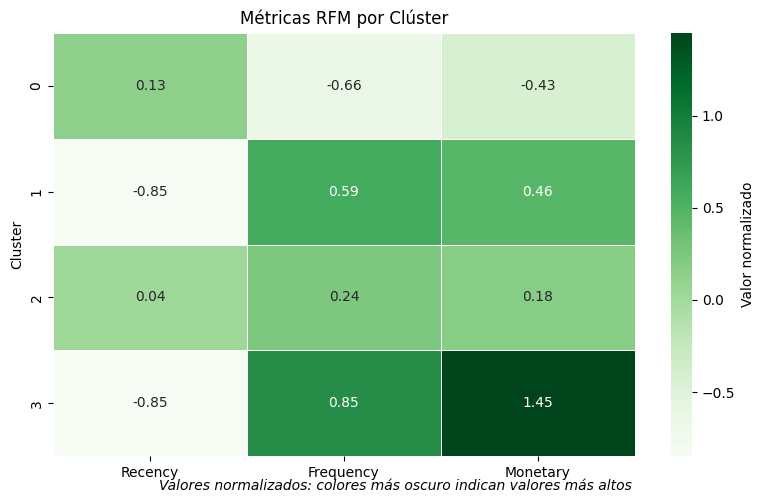

In [38]:
# Calcular medianas por clúster
heatmap_data = df_norm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].median()

# Crear figura con tamaño personalizado
plt.figure(figsize=(10, 6))

# Crear mapa de calor
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_data, annot=True, cmap='Greens', fmt=".2f", linewidths=0.5,cbar_kws={'label': 'Valor normalizado'})
plt.title('Métricas RFM por Clúster')

# Añadir una nota explicativa (opcional)
plt.figtext(0.5, 0.01, 'Valores normalizados: colores más oscuro indican valores más altos',
            ha='center', fontsize=10, style='italic')
plt.tight_layout()
plt.show()

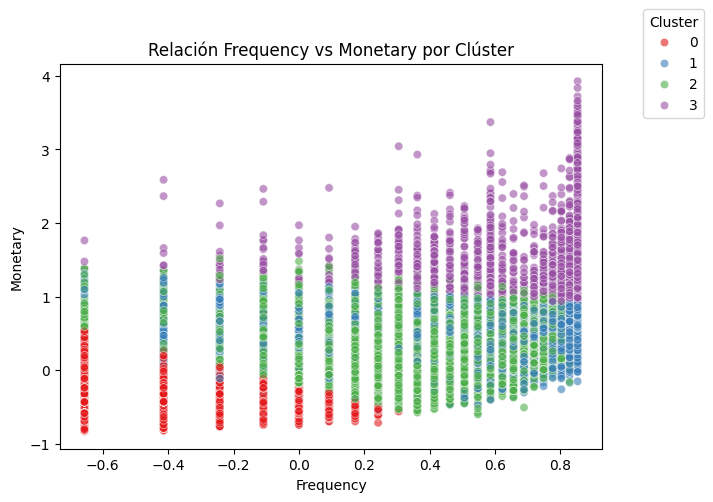

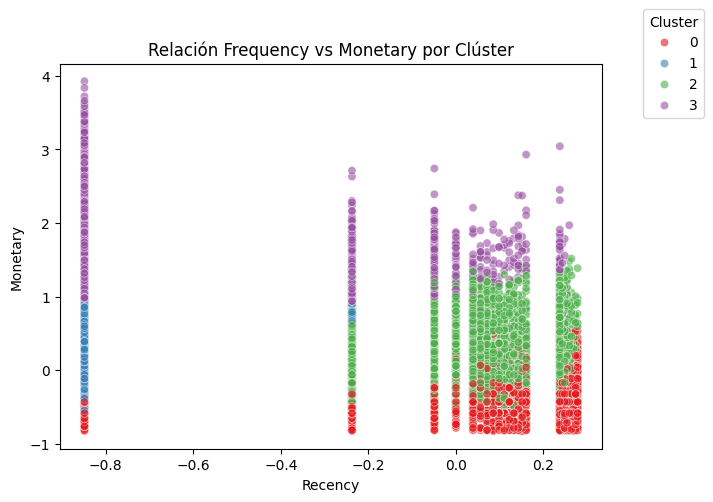

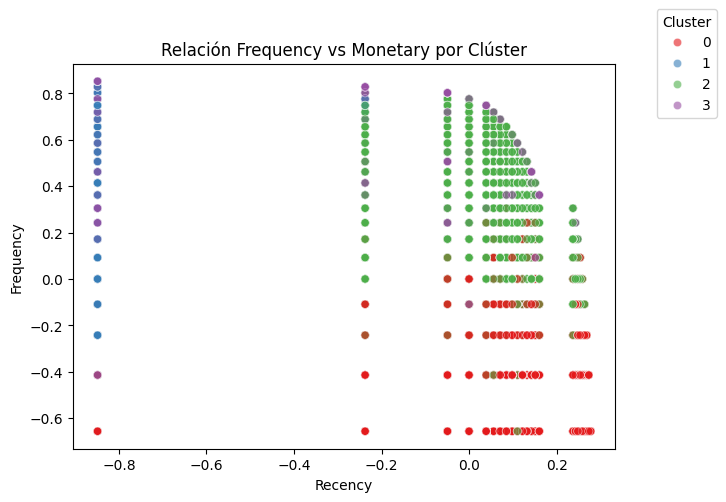

In [39]:
# Crear gráfico de dispersión Frecuencia vs Monetario
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df_norm, x='Frequency', y='Monetary', hue='Cluster', palette='Set1', alpha=0.6)
plt.legend(title='Cluster', loc='right', bbox_to_anchor=(1.2, 1))
plt.title('Relación Frequency vs Monetary por Clúster')
plt.show()

# Crear gráfico de dispersión Recencia vs Monetario
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df_norm, x='Recency', y='Monetary', hue='Cluster', palette='Set1', alpha=0.6)
plt.legend(title='Cluster', loc='right', bbox_to_anchor=(1.2, 1))
plt.title('Relación Frequency vs Monetary por Clúster')
plt.show()

# Crear gráfico de dispersión Frecuencia vs Recencia
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df_norm, x='Recency', y='Frequency', hue='Cluster', palette='Set1', alpha=0.6)
plt.legend(title='Cluster', loc='right', bbox_to_anchor=(1.2, 1))
plt.title('Relación Frequency vs Monetary por Clúster')
plt.show()

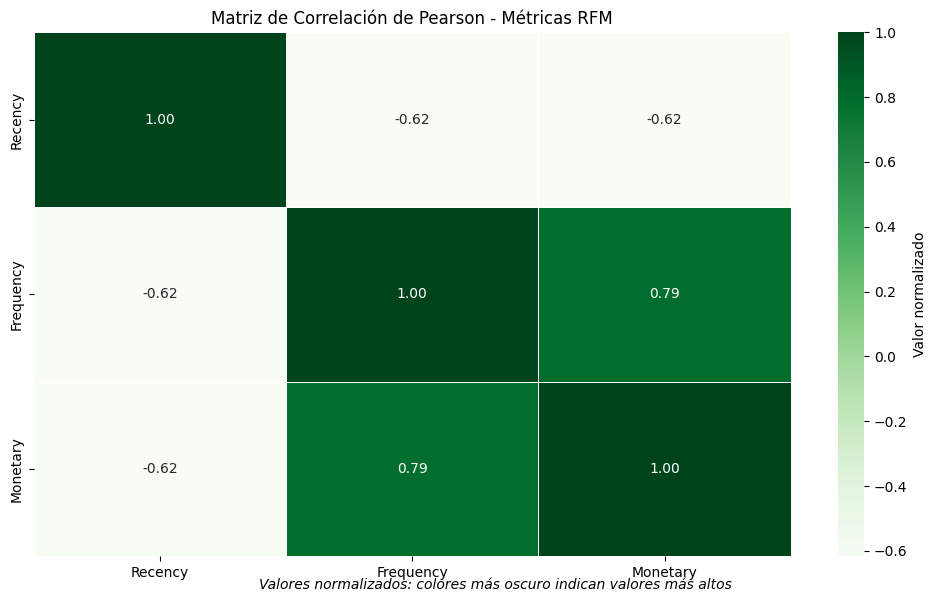

In [40]:
# Calcular la matriz de correlación de Pearson para las métricas RFM
correlation_matriz = df_norm[['Recency', 'Frequency', 'Monetary']].corr(method='pearson')

# Visualizar la matriz con un heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matriz, annot=True, cmap='Greens', fmt=".2f", linewidths=0.5,cbar_kws={'label': 'Valor normalizado'})
plt.title('Matriz de Correlación de Pearson - Métricas RFM')
plt.figtext(0.5, 0.01, 'Valores normalizados: colores más oscuro indican valores más altos',
            ha='center', fontsize=10, style='italic')
plt.tight_layout()
plt.show()




In [41]:
#Calculo de correlacion de pearson por cluster
for c in sorted(df_norm['Cluster'].unique()):
    print(f"\nCorrelación - Clúster {c}")
    display(df_norm[df_norm['Cluster'] == c][['Recency', 'Frequency', 'Monetary']].corr(method='pearson'))



Correlación - Clúster 0


,Recency,Frequency,Monetary
Recency,1.00,0.02,-0.14
Frequency,0.02,1.00,0.30
Monetary,-0.14,0.30,1.00



Correlación - Clúster 1


,Recency,Frequency,Monetary
Recency,1.00,0.11,0.14
Frequency,0.11,1.00,0.44
Monetary,0.14,0.44,1.00



Correlación - Clúster 2


,Recency,Frequency,Monetary
Recency,1.00,-0.35,-0.03
Frequency,-0.35,1.00,0.16
Monetary,-0.03,0.16,1.00



Correlación - Clúster 3


,Recency,Frequency,Monetary
Recency,1.00,-0.41,-0.03
Frequency,-0.41,1.00,0.03
Monetary,-0.03,0.03,1.00


In [42]:
# Filtrar el Clúster 0 desde el DataFrame original normalizado
df_cluster0 = df_norm[df_norm['Cluster'] == 0].copy()


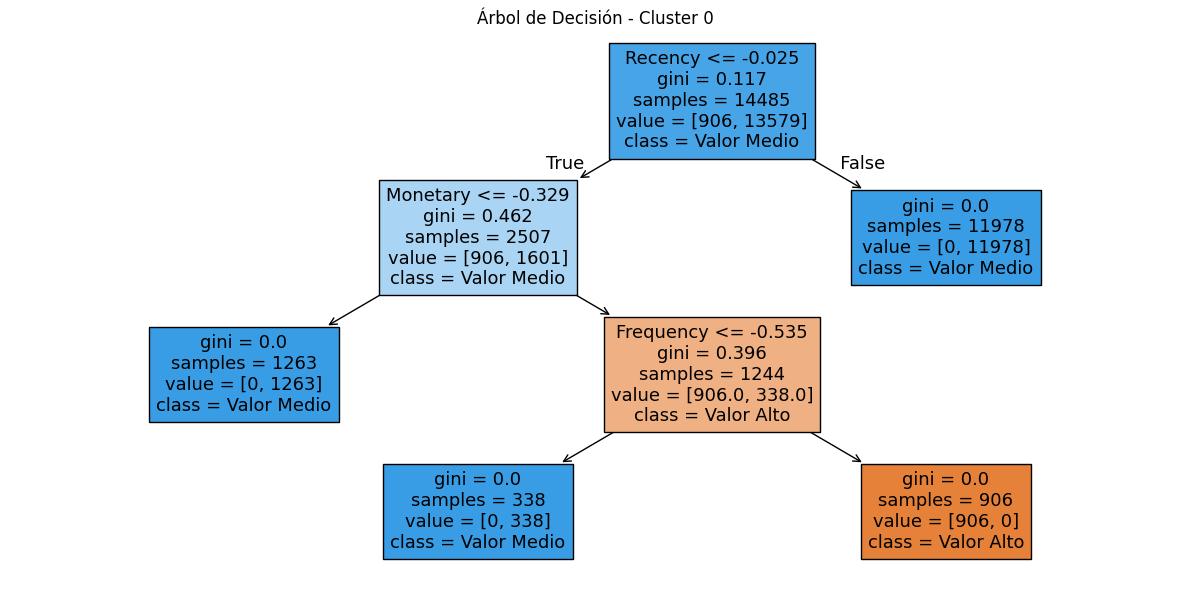

In [43]:
# Filtrar datos del clúster 0
datos_cluster = df_norm[df_norm["Cluster"] == 0].copy()

# Extraer características RFM
X = datos_cluster[["Recency", "Frequency", "Monetary"]]

# Calcular estadísticas para categorización (todo junto)
Me_R, σ_R = datos_cluster['Recency'].median(), datos_cluster['Recency'].std()
Me_F, σ_F = datos_cluster['Frequency'].median(), datos_cluster['Frequency'].std()
Me_M, σ_M = datos_cluster['Monetary'].median(), datos_cluster['Monetary'].std()

# Crear función de categorización
def asignar_categoria(row):
    if row['Recency'] < Me_R - 0.5*σ_R and row['Frequency'] > Me_F + 0.5*σ_F and row['Monetary'] > Me_M + 0.5*σ_M:
        return 'Valor Alto'
    elif row['Recency'] > Me_R + σ_R and row['Frequency'] < Me_F - σ_F and row['Monetary'] < Me_M - σ_M:
        return 'Valor Bajo'
    else:
        return 'Valor Medio'

# Aplicar categorización
datos_cluster['Categoria'] = datos_cluster.apply(asignar_categoria, axis=1)

# Entrenar árbol de decisión
arbol = DecisionTreeClassifier(max_depth=3, random_state=1)
arbol.fit(X, datos_cluster['Categoria'])

# Visualizar árbol
plt.figure(figsize=(12, 6))
plot_tree(arbol, feature_names=["Recency", "Frequency", "Monetary"],
          class_names=sorted(datos_cluster['Categoria'].unique()),
          filled=True)
plt.title("Árbol de Decisión - Cluster 0")
plt.tight_layout()
plt.show()

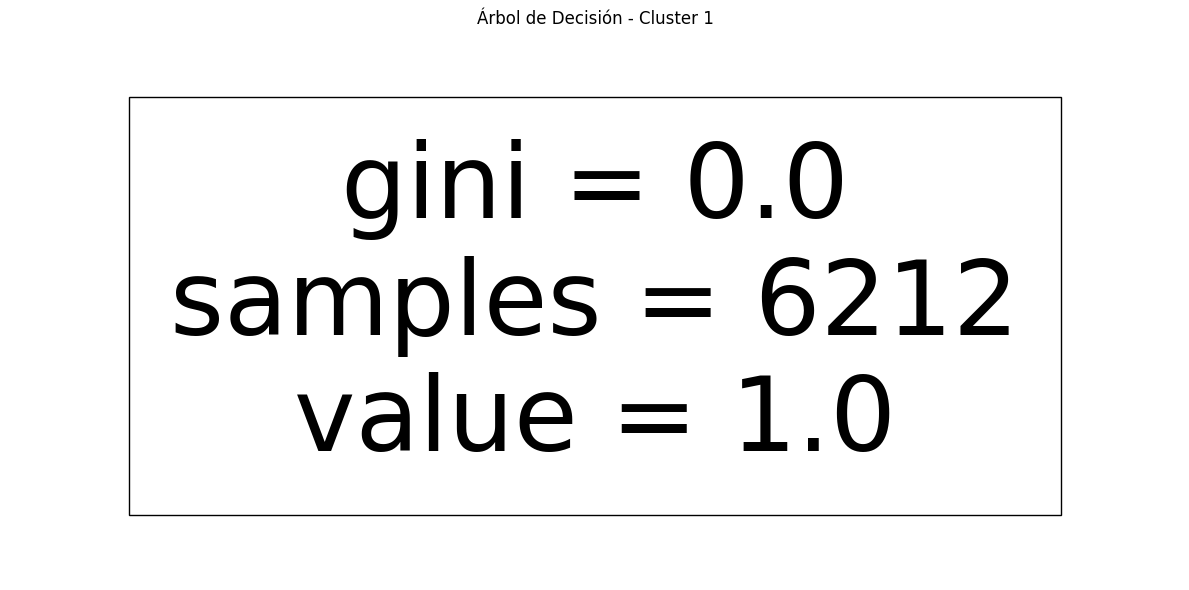

In [44]:
# Filtrar datos del clúster 1
datos_cluster = df_norm[df_norm["Cluster"] == 1].copy()

# Extraer características RFM
X = datos_cluster[["Recency", "Frequency", "Monetary"]]

# Calcular estadísticas para categorización (todo junto)
Me_R, σ_R = datos_cluster['Recency'].median(), datos_cluster['Recency'].std()
Me_F, σ_F = datos_cluster['Frequency'].median(), datos_cluster['Frequency'].std()
Me_M, σ_M = datos_cluster['Monetary'].median(), datos_cluster['Monetary'].std()

# Crear función de categorización
def asignar_categoria(row):
    if row['Recency'] < Me_R - 0.5*σ_R and row['Frequency'] > Me_F + 0.5*σ_F and row['Monetary'] > Me_M + 0.5*σ_M:
        return 'Valor Alto'
    elif row['Recency'] > Me_R + σ_R and row['Frequency'] < Me_F - σ_F and row['Monetary'] < Me_M - σ_M:
        return 'Valor Bajo'
    else:
        return 'Valor Medio'

# Aplicar categorización
datos_cluster['Categoria'] = datos_cluster.apply(asignar_categoria, axis=1)

# Entrenar árbol de decisión
arbol = DecisionTreeClassifier(max_depth=3, random_state=1)
arbol.fit(X, datos_cluster['Categoria'])

# Visualizar árbol
plt.figure(figsize=(12, 6))
plot_tree(arbol, feature_names=["Recency", "Frequency", "Monetary"],
          class_names=sorted(datos_cluster['Categoria'].unique()),
          filled=True)
plt.title("Árbol de Decisión - Cluster 1")
plt.tight_layout()
plt.show()

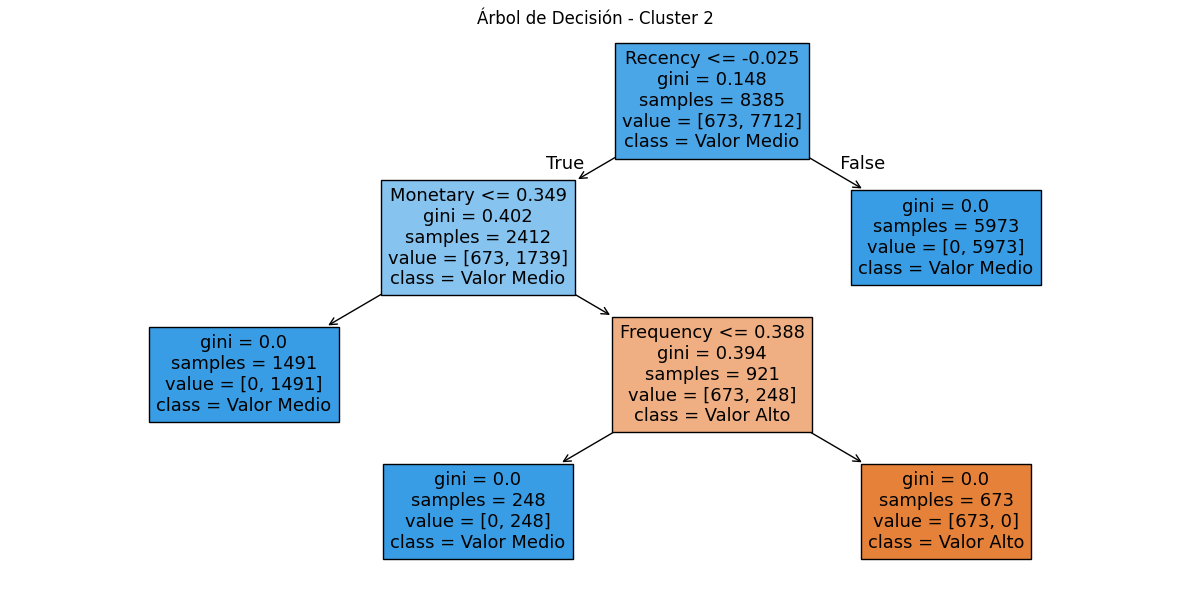

In [45]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
# Filtrar datos del clúster 2
datos_cluster = df_norm[df_norm["Cluster"] == 2].copy()

# Extraer características RFM
X = datos_cluster[["Recency", "Frequency", "Monetary"]]

# Calcular estadísticas para categorización (todo junto)
Me_R, σ_R = datos_cluster['Recency'].median(), datos_cluster['Recency'].std()
Me_F, σ_F = datos_cluster['Frequency'].median(), datos_cluster['Frequency'].std()
Me_M, σ_M = datos_cluster['Monetary'].median(), datos_cluster['Monetary'].std()

# Crear función de categorización
def asignar_categoria(row):
    if row['Recency'] < Me_R - 0.5*σ_R and row['Frequency'] > Me_F + 0.5*σ_F and row['Monetary'] > Me_M + 0.5*σ_M:
        return 'Valor Alto'
    elif row['Recency'] > Me_R + σ_R and row['Frequency'] < Me_F - σ_F and row['Monetary'] < Me_M - σ_M:
        return 'Valor Bajo'
    else:
        return 'Valor Medio'

# Aplicar categorización
datos_cluster['Categoria'] = datos_cluster.apply(asignar_categoria, axis=1)

# Entrenar árbol de decisión
arbol = DecisionTreeClassifier(max_depth=3, random_state=1)
arbol.fit(X, datos_cluster['Categoria'])

# Visualizar árbol
plt.figure(figsize=(12, 6))
plot_tree(arbol, feature_names=["Recency", "Frequency", "Monetary"],
          class_names=sorted(datos_cluster['Categoria'].unique()),
          filled=True)
plt.title("Árbol de Decisión - Cluster 2")
plt.tight_layout()
plt.show()

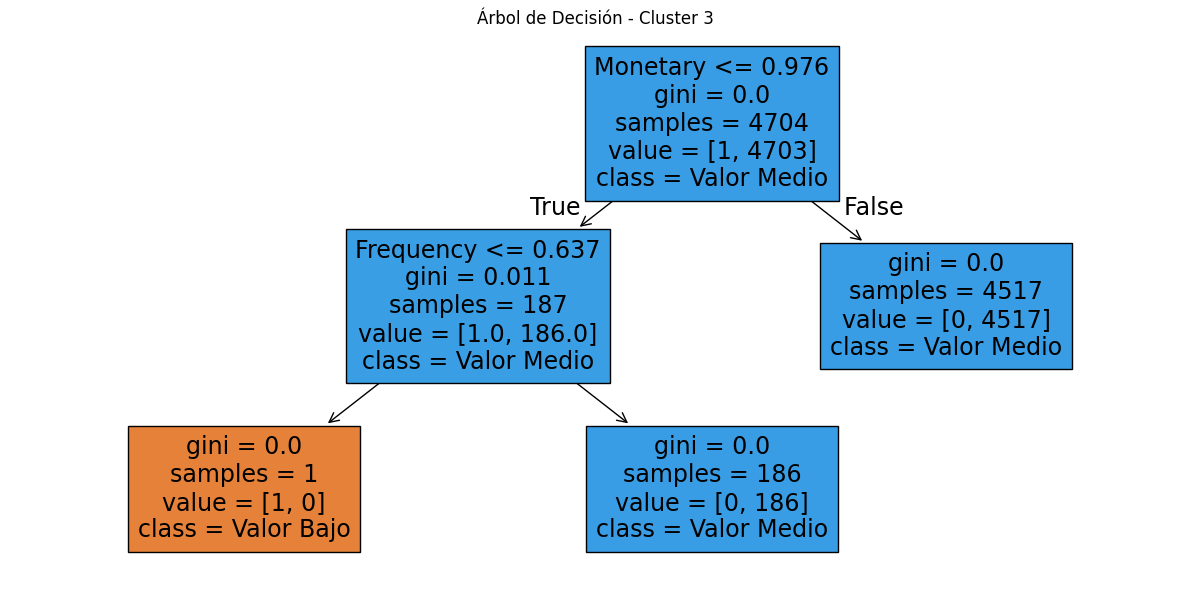

In [46]:
# Filtrar datos del clúster N
datos_cluster = df_norm[df_norm["Cluster"] == 3].copy()

# Extraer características RFM
X = datos_cluster[["Recency", "Frequency", "Monetary"]]

# Calcular estadísticas para categorización (todo junto)
Me_R, σ_R = datos_cluster['Recency'].median(), datos_cluster['Recency'].std()
Me_F, σ_F = datos_cluster['Frequency'].median(), datos_cluster['Frequency'].std()
Me_M, σ_M = datos_cluster['Monetary'].median(), datos_cluster['Monetary'].std()

# Crear función de categorización
def asignar_categoria(row):
    if row['Recency'] < Me_R - 0.5*σ_R and row['Frequency'] > Me_F + 0.5*σ_F and row['Monetary'] > Me_M + 0.5*σ_M:
        return 'Valor Alto'
    elif row['Recency'] > Me_R + σ_R and row['Frequency'] < Me_F - σ_F and row['Monetary'] < Me_M - σ_M:
        return 'Valor Bajo'
    else:
        return 'Valor Medio'

# Aplicar categorización
datos_cluster['Categoria'] = datos_cluster.apply(asignar_categoria, axis=1)

# Entrenar árbol de decisión
arbol = DecisionTreeClassifier(max_depth=3, random_state=1)
arbol.fit(X, datos_cluster['Categoria'])

# Visualizar árbol
plt.figure(figsize=(12, 6))
plot_tree(arbol, feature_names=["Recency", "Frequency", "Monetary"],
          class_names=sorted(datos_cluster['Categoria'].unique()),
          filled=True)
plt.title("Árbol de Decisión - Cluster 3")
plt.tight_layout()
plt.show()